# DX 704 Week 3 Project

This week's project will give you practice with optimizing choices for bandit algorithms.
You will be given access to the bandit problem via a blackbox object, and you will investigate the bandit rewards to pick a suitable algorithm.

The full project description, a template notebook and supporting code are available on GitHub: [Project 3 Materials](https://github.com/bu-cds-dx704/dx704-project-03).


## Example Code

You may find it helpful to refer to these GitHub repositories of Jupyter notebooks for example code.

* https://github.com/bu-cds-omds/dx601-examples
* https://github.com/bu-cds-omds/dx602-examples
* https://github.com/bu-cds-omds/dx603-examples
* https://github.com/bu-cds-omds/dx704-examples

Any calculations demonstrated in code examples or videos may be found in these notebooks, and you are allowed to copy this example code in your homework answers.

## Part 1: Pick a Bandit Algorithm

Experiment with the multi-armed bandit interface using seed 0 to learn about the distribution of rewards and decide what kind of bandit algorithm will be appropriate.
A histogram will likely be helpful.

In [85]:
# DO NOT CHANGE

import numpy as np

class BanditProblem(object):
    def __init__(self, seed):
        self.seed = seed
        self.rng = np.random.default_rng(seed)

        self.num_arms = 3
        self.ns = self.rng.integers(low=1, high=10, size=self.num_arms)
        self.ps = self.rng.uniform(low=0.2, high=0.4, size=self.num_arms)

    def get_num_arms(self):
        return self.num_arms

    def get_reward(self, arm):
        if arm < 0 or arm >= self.num_arms:
            raise ValueError("Invalid arm")

        x = self.rng.uniform()
        x *= self.rng.binomial(self.ns[arm], self.ps[arm])

        return x


In [86]:
bandit0 = BanditProblem(0)

In [87]:
bandit0.get_num_arms()

3

In [88]:
bandit0.get_reward(arm=0)

1.8255111545554434

Reward summary (seed 0):


,arm,mean,std,min,p50,p95,max
0,0,0.8319,0.8187,0.0,0.6417,2.5001,6.7825
1,1,0.6068,0.6743,0.0,0.4339,1.9236,4.8232
2,2,0.9043,0.8199,0.0,0.7105,2.5784,4.9981


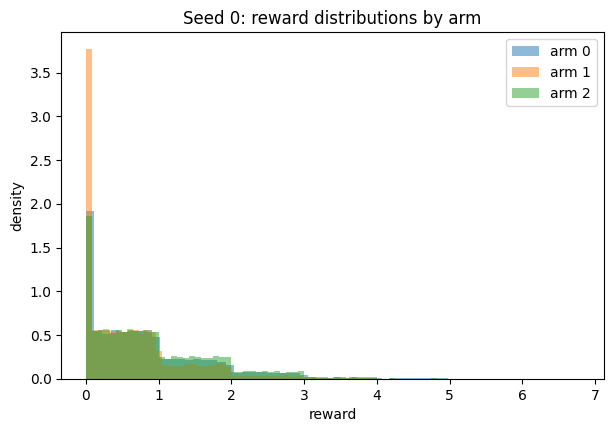

Wrote algorithm-choice.txt


In [89]:
# YOUR CHANGES HERE


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


K = bandit0.get_num_arms()

N = 20000
samples = {a: np.array([bandit0.get_reward(a) for _ in range(N)], dtype=float) for a in range(K)}

# The summary table
summary = pd.DataFrame(
    [{"arm": a,
      "mean": v.mean(),
      "std": v.std(ddof=1),
      "min": v.min(),
      "p50": np.percentile(v, 50),
      "p95": np.percentile(v, 95),
      "max": v.max()} for a, v in samples.items()]
).round(4)
print("Reward summary (seed 0):")
display(summary)

# histograms
plt.figure(figsize=(7, 4.5))
for a, v in samples.items():
    plt.hist(v, bins=60, alpha=0.5, density=True, label=f"arm {a}")
plt.xlabel("reward"); plt.ylabel("density")
plt.title("Seed 0: reward distributions by arm")
plt.legend(); plt.show()

# Sentences justifying my choice and rejecting the alternatives
choice_text = (
    "Algorithm choice: UCB1."
    "Why I choose to use this: The rewards are steady over time and have an upper limit. "
    "UCB1 works well and doesn’t need any tuning. It tries all arms, "
    "then keeps picking the one that looks best while still giving a little bonus "
    "to arms we’re less sure about."
    "Why I choose to not use others: ε-greedy and softmax need knobs to tune  "
    "and can do poorly if those are set badly. Thompson sampling needs a good "
    "probability model for the rewards, which is extra complexity here."
    "Bottom line: I beleive UCB1 is the simplest, reliable choice for these bounded rewards."
)
with open("algorithm-choice.txt", "w") as f:
    f.write(choice_text)
print("Wrote algorithm-choice.txt")


Based on your investigation, pick an appropriate bandit algorithm to implement from the algorithms covered this week.
Write a file "algorithm-choice.txt" that states your choice and gives a few sentences justifying your choice and rejecting the alternatives.
Keep your explanation concise; overly verbose responses will be penalized.

## Part 2: Implement Bandit

Based on your decision, implement an appropriate bandit algorithm and pick 1000 actions using seed 2025002.

In [90]:
# YOUR CHANGES HERE


import numpy as np
import pandas as pd

def run_ucb1(seed: int = 2025002, T: int = 1000, B: float = 9.0):
    bandit = BanditProblem(seed)
    K = bandit.get_num_arms()

    rng = np.random.default_rng(seed + 7)   

    actions, rewards = [], []
    counts = np.zeros(K, dtype=int)
    sum_scaled = np.zeros(K, dtype=float)   

    for a in range(K):
        r = bandit.get_reward(a)
        counts[a] += 1
        sum_scaled[a] += min(r / B, 1.0)
        actions.append(a)
        rewards.append(r)

    # UCB1 loop
    for t in range(K, T):
        t1 = t + 1.0
        avg = sum_scaled / counts
        bonus = np.sqrt(2.0 * np.log(t1) / counts)
        ucb = avg + bonus

        best = np.flatnonzero(ucb == ucb.max())
        a = int(rng.choice(best))

        r = bandit.get_reward(a)
        counts[a] += 1
        sum_scaled[a] += min(r / B, 1.0)
        actions.append(a)
        rewards.append(r)

    return pd.DataFrame({"action": actions, "reward": rewards})




Write a file "history.tsv" with columns action and reward in the order that the actions were taken.

In [91]:
# YOUR CHANGES HERE

history = run_ucb1(seed=2025002, T=1000, B=9.0)
history.to_csv("history.tsv", sep="\t", index=False, float_format="%.6f")
print(f"Saved history.tsv with {len(history)} rows.")
history.head()

Saved history.tsv with 1000 rows.


,action,reward
0,0,1.575207
1,1,0.000000
2,2,0.000000
3,0,1.804006
4,1,0.432083


Submit "history.tsv" in Gradescope.

## Part 3: Action Statistics

Based on the data from part 2, estimate the expected reward for each arm and write a file "actions.tsv" with the columns arm, min_reward, mean_reward, max_reward.

In [92]:
# YOUR CHANGES HERE


import pandas as pd
import numpy as np

HIST_FILE = "history.tsv"
OUT_FILE  = "actions.tsv"

hist = pd.read_csv(HIST_FILE, sep="\t")
assert {"action", "reward"}.issubset(hist.columns)

try:
    K = BanditProblem(2025002).get_num_arms()  
except NameError:
    K = 3

summary = (
    hist.groupby("action")["reward"]
        .agg(min_reward="min", mean_reward="mean", max_reward="max")
        .reset_index()
)

full = pd.DataFrame({"action": np.arange(K)})
summary = full.merge(summary, on="action", how="left").fillna(0.0).sort_values("action")

summary.to_csv(OUT_FILE, sep="\t", index=False, float_format="%.6f")
print(f" {OUT_FILE} with {len(summary)} rows.")
summary


 actions.tsv with 3 rows.


,action,min_reward,mean_reward,max_reward
0,0,0.0,0.597758,3.761461
1,1,0.0,0.531647,2.988922
2,2,0.0,0.176597,0.966617


Submit "actions.tsv" in Gradescope.

## Part 4: Regret Estimates

Calculate the expected regret taking 1000 actions with the following strategies.

* uniform: Pick an arm uniformly at random.
* just-i: Always pick arm $i$. Do this for $i=0$ to $K-1$ where $K$ is the number of arms.
* actual: This should match your output in part 2.

In [93]:
# YOUR CHANGES HERE


import pandas as pd
import numpy as np

T = 1000
ACTIONS_FILE = "actions.tsv"
HIST_FILE    = "history.tsv"
OUT_FILE     = "strategies.tsv"

actions = pd.read_csv(ACTIONS_FILE, sep="\t")
assert {"action", "mean_reward"}.issubset(actions.columns)

mu_per_arm = actions.set_index("action")["mean_reward"].to_dict()
K = len(mu_per_arm)
mu_star = max(mu_per_arm.values())
mu_mean = sum(mu_per_arm.values()) / K

rows = []

rows.append({"strategy": "uniform", "regret": T * (mu_star - mu_mean)})

for i in range(K):
    rows.append({"strategy": f"just-{i}", "regret": T * (mu_star - mu_per_arm[i])})



Write your results to a file "strategies.tsv" with the columns strategy and regret.

In [94]:
# YOUR CHANGES HERE

hist = pd.read_csv(HIST_FILE, sep="\t")
assert {"action", "reward"}.issubset(hist.columns)
real_total = hist["reward"].sum()
rows.append({"strategy": "actual", "regret": T * mu_star - real_total})

strategies = pd.DataFrame(rows)
strategies.to_csv(OUT_FILE, sep="\t", index=False, float_format="%.6f")
print(f"Saved {OUT_FILE} with {len(strategies)} rows.")
strategies


Saved strategies.tsv with 5 rows.


,strategy,regret
0,uniform,162.42400
1,just-0,0.00000
2,just-1,66.11100
3,just-2,421.16100
4,actual,129.15599


Submit "strategies.tsv" in Gradescope.

## Part 5: Acknowledgments

Make a file "acknowledgments.txt" documenting any outside sources or help on this project.
If you discussed this assignment with anyone, please acknowledge them here.
If you used any libraries not mentioned in this module's content, please list them with a brief explanation what you used them for.
If you used any generative AI tools, please add links to your transcripts below, and any other information that you feel is necessary to comply with the generative AI policy.
If no acknowledgements are appropriate, just write none in the file.


Submit "acknowledgments.txt" in Gradescope.

In [95]:
from textwrap import dedent

ack = dedent("""\
Acknowledgments


The Libraries/Tools used 
- NumPy — arrays and random number generation.
- Pandas — reading/writing TSV files and simple summaries.
- Matplotlib — quick histograms to inspect reward distributions.

Data
- I used the course provided files 
- Also course example notebooks (dx601/dx602/dx603/dx704) for general patterns and review .


People/Collaboration
- I discussed this assignment with no one and did not use any additional sources beyond the course materials,
other than occasional Google searches to help understand concepts covered in class. 

""")

with open("acknowledgments.txt", "w", encoding="utf-8") as f:
    f.write(ack)

print(" acknowledgments.txt")

 acknowledgments.txt


## Part 6: Code

Please submit a Jupyter notebook that can reproduce all your calculations and recreate the previously submitted files.

Submit "project.ipynb" in Gradescope.